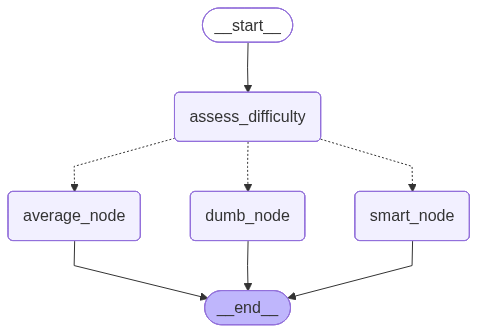

In [ ]:
# routing.ipynb
from typing_extensions import TypedDict, Literal
from typing import List
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o")

dumb_llm = init_chat_model("openai:gpt-3.5-turbo")
average_llm = init_chat_model("openai:gpt-4o")
smart_llm = init_chat_model("openai:gpt-5-2025-08-07")

class State(TypedDict):

    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]

def dumb_node(state: State):
    response = dumb_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-3.5",
    }


def average_node(state: State):
    response = average_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-4o",
    }


def smart_node(state: State):
    response = smart_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-o3",
    }


def assess_difficulty(state: State):
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(
        f"""
        Assess the difficulty of this question
        Question: {state["question"]}

        - EASY: Simple facts, basic definitions, yes/no answers
        - MEDIUM: Requires explanation, comparison, analysis
        - HARD: Complex reasoning, multiple steps, deep expertise.
        """
    )

    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    elif difficulty_level == "hard":
        goto = "smart_node"

    return Command(
        goto=goto,
        update={
            "difficulty": difficulty_level,
        },
    )
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=(
        "dumb_node",
        "average_node",
        "smart_node",
    ),
)

graph_builder.add_edge(
    START,
    "assess_difficulty",
)
graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

graph

In [ ]:
# 실행 금지
# graph.invoke({"question": "Investment potential of Uranium in 2026"})